In [351]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

In [352]:
from utils import MLP, train

## Dataset: Digits

In this example, we use a dataset that even simpler than the traditional MNIST dataset we have studied so far: We use a scipy dataset called Digits. It consists of ~1500 images of size 8x8, and each pixel can take values in $\{0, 1, \ldots, 16\}$.


In [353]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [354]:
transforms = tt.Lambda(lambda x: 2. * (x / 17.) - 1.)  # changing to [-1, 1]

In [355]:
train_data = Digits(mode='train', transforms=transforms)
val_data = Digits(mode='val', transforms=transforms)
test_data = Digits(mode='test', transforms=transforms)

training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Let's have a look at some of the samples of the dataset. The samples are already flattened to a 1D array of size 64, so we have to reshape them to get the full image.

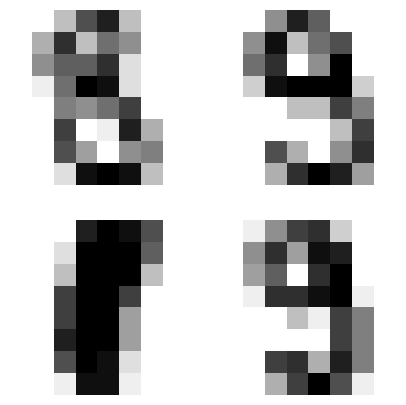

In [356]:
plt.figure(figsize=(5,5))

for i in range(4):
    id_random = np.random.randint(0,999)
    image = train_data.data[id_random]
    
    plt.subplot(2,2,i+1)
    plt.axis('off')
    plt.imshow(image.reshape(8,8), cmap="gray_r")



## Score-based Generative Model

In [ ]:
class ScoreBasedGenerativeModel(nn.Module):
    def __init__(self,  sigma, D, T):
        super(ScoreBasedGenerativeModel, self).__init__()

        """
        Parameters:
        -----------
        sigma : float
            The parameter controlling the noise level in the score-based generative model.
        D : int
            The dimensionality of the data distribution.
        T : float
            The maximum time horizon for the model.

        Attributes:
        -----------
        sigma : torch.Tensor
            The noise parameter wrapped in a PyTorch tensor.
        base : torch.distributions.MultivariateNormal
            The base distribution, modeled as a multivariate Gaussian with diagonal covariance.
        snet : torch.nn.Module
            The score network used for approximating the score function.
        time_embedding : torch.nn.Sequential
            A simple time embedding module consisting of a linear layer followed by a Tanh activation.
        D : int
            Dimensionality of the data distribution.
        T : float
            Number of timesteps.
        EPS : float
            A small constant used for numerical stability.
        """
        
        # sigma parameter
        self.sigma = torch.Tensor([sigma])
        
        # variance of the base, i.e, sigma_t evaluated at t=1
        var = (1./(2.* torch.log(self.sigma))) * (self.sigma**2 - 1.)

        # base distribution
        self.base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(D), var * torch.eye(D))
        
        # time embedding (a single linear layer)
        self.time_embedding = nn.Sequential(nn.Linear(1, D), nn.Tanh())
        
        # dimensionality
        self.dim = D

        print("D: ", D)
        
        # number of time steps
        self.n_time_steps = T
                
        # for numerical stability
        self.EPS = 1.e-5

        conv_model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Output: (16, 8, 8)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 8, 8)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: (64, 8, 8)
            nn.ReLU(),
            nn.Flatten(),  # Flatten the output: (B, 64 * 8 * 8)
            nn.Linear(64 * 8 * 8, D),  # Output: (B, D) for score function
        )

        # score model (MLP architecture)
        linear_model = nn.Sequential(
            nn.Linear(D, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, D)  # Ensure that this matches D = 64
        )

        self.s_net = conv_model
        
    def sigma_t(self, t):
        """
        Computes the time-dependent standard deviation (sigma) of the distribution.

        This function calculates the standard deviation based on the given parameter `t`.
        It uses the `self.sigma` attribute as a base parameter to derive the value.

        Args:
            t (float or Tensor): The time variable, which determines the evolution of the standard deviation.

        Returns:
            Tensor: The computed standard deviation at time `t`.

        Notes:
            The formula used is:
                sqrt((1 / (2 * log(self.sigma))) * (self.sigma^(2t) - 1))
            where `self.sigma` is the base parameter of the distribution.
        """
        return torch.sqrt((1./(2. * torch.log(self.sigma))) * (self.sigma**(2.*t) - 1.))

    def sample_base(self, shape):
        """
        Samples from the base distribution.

        This function generates samples from the base distribution defined by `self.base`. 
        The number and structure of samples are determined by the provided `shape`.

        Args:
            shape (tuple): The desired shape of the samples.

        Returns:
            Tensor: A tensor of samples drawn from the base distribution.

        Notes:
            This method uses the `rsample` function to allow for reparameterized gradients, 
            which is useful in optimization contexts like variational inference.
        """
        output = self.base.rsample(sample_shape=(shape[0],))  # Shape should be (n_samples, 64)
        print(f"Sample base output shape: {output.shape}")  # Debugging line
        return output
        
    def sample_p_t(self, x_0, x_1, t):
        """
        Samples from the conditional distribution \( p_{0t}(x_t \mid x_0) \).

        This function generates a sample at time `t` given:
        - `x_0`, which represents the data sample,
        - `x_1`, which represents noise,
        using a scaling factor derived from the time-dependent standard deviation (`sigma_fun(t)`).

        Args:
            x_0 (Tensor): The data sample.
            x_1 (Tensor): The noise sample.
            t (float or Tensor): The time variable that modulates the noise's influence.

        Returns:
            Tensor: The generated sample \( x_t \) at time `t`.

        Notes:
            The computation follows the formula:
                \( x_t = x_0 + \sigma(t) \cdot x_1 \)
            where \( \sigma(t) \) is the time-dependent standard deviation computed by `sigma_fun(t)`.
        """
        return x_0 + self.sigma_t(t) * x_1 # YOUR IMPLEMENTATION HERE
    
    def diffusion_coeff(self, t):
        """
        Computes the diffusion coefficient of the stochastic differential equation (SDE).

        The diffusion coefficient is time-dependent and is calculated as a power of 
        the base parameter `self.sigma` raised to `t`.

        Args:
            t (float or Tensor): The time variable, which determines the diffusion coefficient's value.

        Returns:
            Tensor: The diffusion coefficient at time `t`.

        Notes:
            The formula used is:
                \( g(t) = \sigma^t \)
            where `\sigma` is a constant parameter defined by `self.sigma`.
        """
        return self.sigma**t
    
    def forward(self):
        return self.s_net # YOUR IMPLEMENTATION HERE

    def sample(self, n_samples):
        """
        Generate samples using a diffusion-based process with backward Euler's method.

        This function generates samples starting from a base distribution and iteratively
        refines them using a backward Euler method. It applies a diffusion process to
        transition from noise to the desired distribution over time.

        Args:
            n_samples (int, optional): Number of samples to generate.

        Returns:
            torch.Tensor: A tensor containing the generated samples with shape (batch_size, self.D).

        Method:
        1. Initialize the samples (x_t) by drawing from a base distribution defined by
           Normal(0, 1 / (2 * log(sigma)) * (sigma^2 - 1)).
        2. Iterate through a sequence of time steps `ts` from 1 to `EPS` using backward Euler's method.
           - Compute the time step size `delta_t`.
           - For each time step:
             - Use the diffusion coefficient and score network to calculate the update direction.
             - Update `x_t` using the backward Euler update formula.
        3. Apply a hyperbolic tangent (tanh) transformation to the final samples to constrain the output.

        Notes:
        - `x_0` corresponds to the data distribution.
        - `x_1` corresponds to the noise distribution.
        - The time steps are processed in reverse, consistent with the backward Euler method.

        Example Usage:
            samples = model.sample(batch_size=128)

        """
    # Sample x_t from the base distribution (using sample_base function)
        print("self.dim: ", self.dim)
        x_t = self.sample_base((n_samples, self.dim))  # Shape: (n_samples, D)

        # Debugging line to check initial shape
        print(f"Initial x_t shape: {x_t.shape}")  # Debugging line: Check initial shape

        # Reshape x_t to match the image dimensions (since we're generating 8x8 images)
        x_t = x_t.view(n_samples, 1, 8, 8)  # Reshape to (n_samples, 1, 8, 8) for 8x8 MNIST

        # Debugging: Check shape after reshaping
        print(f"x_t shape after reshaping to 8x8: {x_t.shape}")

        # Backward Euler steps for refining the samples
        times = torch.linspace(1., self.EPS, self.n_time_steps)
        delta_t = times[0] - times[1]
        
        for t in times[1:]:
            tt = torch.Tensor([t])
            # Compute the update step using the score network
            u = 0.5 * self.diffusion_coeff(tt) * self.s_net(x_t.view(n_samples, self.dim) + self.time_embedding(tt))
            x_t = x_t - delta_t * u.view(n_samples, 1, 8, 8)  # Ensure the update matches the image shape

            # Debugging: Check shape during each time step
            print(f"x_t shape during step {t}: {x_t.shape}")

        # Apply tanh to constrain the values (for proper image intensity)
        x_t = torch.tanh(x_t)

        # Final debugging: Check the final shape
        print(f"Final x_t shape: {x_t.shape}")

        return x_t






<>:122: SyntaxWarning: invalid escape sequence '\('
<>:146: SyntaxWarning: invalid escape sequence '\('
<>:122: SyntaxWarning: invalid escape sequence '\('
<>:146: SyntaxWarning: invalid escape sequence '\('
/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_49131/610561805.py:122: SyntaxWarning: invalid escape sequence '\('
  """
/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_49131/610561805.py:146: SyntaxWarning: invalid escape sequence '\('
  """


## Experiments

In [358]:

# input dimension
DIM = 64   

# Number of time steps
n_time_steps = 20

sigma = 1.01


num_epochs = 1000

In [359]:
# Initialize model, optimizer, and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ScoreBasedGenerativeModel(sigma=sigma, D=DIM, T=n_time_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
test_losses = []

D:  64


In [360]:

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for batch in training_loader:
        # Move batch to device
        x_0 = batch.to(device)  # Data samples x0
        batch_size = x_0.size(0)
        
        # Step 1: Draw samples
        x_1 = torch.randn(batch_size, DIM, device=device)  # Noise samples x1
        t = torch.rand(batch_size, 1, device=device)  # Uniform time samples t
        sigma_t = model.sigma_t(t)  # Compute sigma(t)
        x_t = x_0 + sigma_t * x_1  # Generate samples xt
        t_embedded = model.time_embedding(t)  # Time embedding
        
        # Step 2: Score network prediction
        predicted_score = model.s_net(x_t + t_embedded)  # sθ(x_t + ˜t)
        
        # Step 3: Compute loss
        loss = torch.mean(
            (sigma_t ** 2) * torch.sum((x_1 - sigma_t * predicted_score) ** 2, dim=1)
        )
        
        # Step 4: Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()

    # Store training loss
    train_losses.append(total_train_loss / len(training_loader))
    
    # Evaluate on test set
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            x_0 = batch.to(device)  # Data samples x0
            batch_size = x_0.size(0)
            
            # Step 1: Draw samples
            x_1 = torch.randn(batch_size, DIM, device=device)  # Noise samples x1
            t = torch.rand(batch_size, 1, device=device)  # Uniform time samples t
            sigma_t = model.sigma_t(t)  # Compute sigma(t)
            x_t = x_0 + sigma_t * x_1  # Generate samples xt
            t_embedded = model.time_embedding(t)  # Time embedding
            
            # Step 2: Score network prediction
            predicted_score = model.s_net(x_t + t_embedded)  # sθ(x_t + ˜t)
            
            # Step 3: Compute loss
            loss = torch.mean(
                (sigma_t ** 2) * torch.sum((x_1 - sigma_t * predicted_score) ** 2, dim=1)
            )
            
            total_test_loss += loss.item()

    # Store test loss
    test_losses.append(total_test_loss / len(test_loader))

    # Log epoch progress
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Save the trained model
torch.save(model.state_dict(), "score_based_model.pth")

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 64]

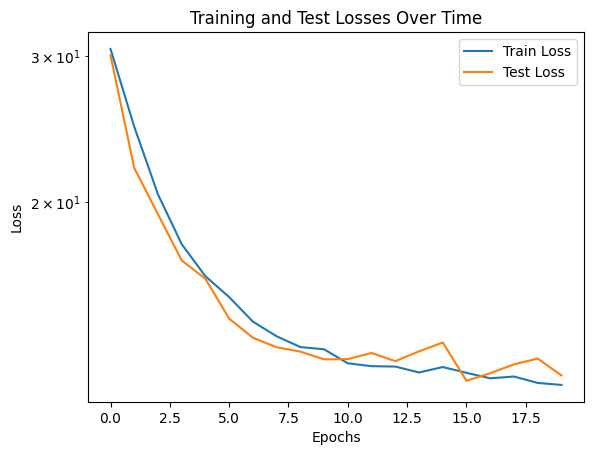

In [ ]:

# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Test Losses Over Time')
plt.legend()
plt.show()


In [ ]:
#  Number of samples to generate
n_samples = 10

# Generate samples using the model's sample method
generated_samples = model.sample(n_samples)

# Since the dataset is transformed to [-1, 1], reverse the transformation for visualization
generated_samples = (generated_samples + 1) * 8.5  # Rescale back to [0, 17]
generated_samples = generated_samples.cpu().detach().numpy().astype(np.uint8)  # Convert to integer range

# Fetch the original samples from the dataset for comparison
original_samples = train_data.data[:n_samples]  # Get the first 10 original samples for comparison
original_samples = (original_samples / 8.5) - 1  # Transform them back to [-1, 1]



self.dim:  64
Sample base output shape: torch.Size([10, 64])
Initial x_t shape: torch.Size([10, 64])
x_t shape after reshaping to 8x8: torch.Size([10, 1, 8, 8])
x_t shape during step 0.9473689794540405: torch.Size([10, 1, 8, 8])
x_t shape during step 0.8947378993034363: torch.Size([10, 1, 8, 8])
x_t shape during step 0.842106819152832: torch.Size([10, 1, 8, 8])
x_t shape during step 0.7894757986068726: torch.Size([10, 1, 8, 8])
x_t shape during step 0.7368447780609131: torch.Size([10, 1, 8, 8])
x_t shape during step 0.6842136979103088: torch.Size([10, 1, 8, 8])
x_t shape during step 0.6315826177597046: torch.Size([10, 1, 8, 8])
x_t shape during step 0.5789515972137451: torch.Size([10, 1, 8, 8])
x_t shape during step 0.5263205766677856: torch.Size([10, 1, 8, 8])
x_t shape during step 0.473689466714859: torch.Size([10, 1, 8, 8])
x_t shape during step 0.42105841636657715: torch.Size([10, 1, 8, 8])
x_t shape during step 0.3684273660182953: torch.Size([10, 1, 8, 8])
x_t shape during step 0.

Generated samples shape: (10, 1, 8, 8)
Generated sample 0 shape: (8, 8)
Generated sample 1 shape: (8, 8)
Generated sample 2 shape: (8, 8)
Generated sample 3 shape: (8, 8)
Generated sample 4 shape: (8, 8)
Generated sample 5 shape: (8, 8)
Generated sample 6 shape: (8, 8)
Generated sample 7 shape: (8, 8)
Generated sample 8 shape: (8, 8)
Generated sample 9 shape: (8, 8)


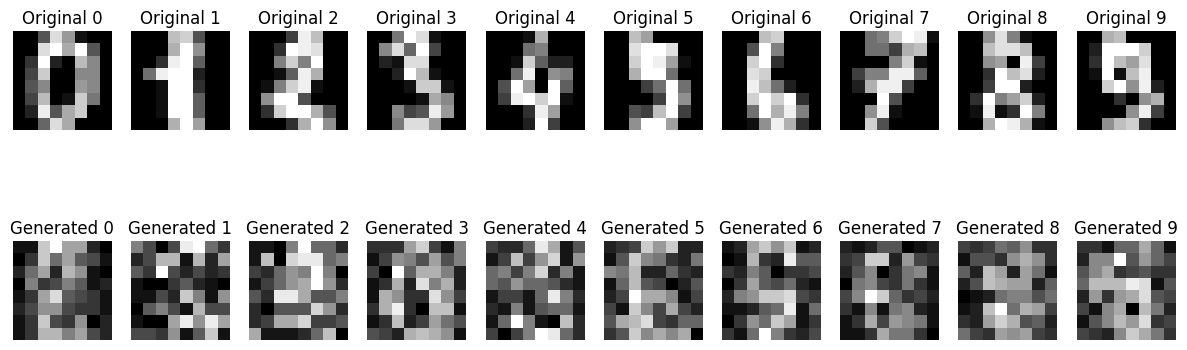

In [ ]:
# Check the shape of generated_samples
print(f"Generated samples shape: {generated_samples.shape}")

fig, axes = plt.subplots(2, n_samples, figsize=(15, 5))

# Display original samples
for i in range(n_samples):
    axes[0, i].imshow(original_samples[i].reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i}')

# Display generated samples as 64x64
for i in range(n_samples):
    sample = generated_samples[i].reshape(8,8)
    print(f"Generated sample {i} shape: {sample.shape}")
    axes[1, i].imshow(sample, cmap='gray')  # Display the full 64x64 image
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Generated {i}')

plt.show()

